<a href="https://colab.research.google.com/github/shahpriyankaj/iedgar_sec_filing_analysis/blob/main/edgar_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Task #1 - Engineering
Given a set of documents: create a solution that allows the end user to understand the documents in a two dimensional space and to identify outliers.

In [2]:
# Installation steps for PySpark on Google Collab
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz # Download Apache Sparks.
!tar xf spark-3.4.4-bin-hadoop3.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [3]:
# Set environment variables to use PySpark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3"

!ls

# Initialize findspark
import findspark
findspark.init()

# Create a PySpark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

sample_data		   spark-3.1.1-bin-hadoop3.2.tgz  spark-3.4.4-bin-hadoop3.tgz
spark-3.1.1-bin-hadoop3.2  spark-3.4.4-bin-hadoop3


In [ ]:
# Installing datasets library to download the data from Huggingface
!pip install -q datasets

In [6]:
import datasets

# Load the dataset of Year 2020 from https://huggingface.co/datasets/eloukas/edgar-corpus. Below code was mentioned on Huggingface to download yearly or entire dataset.
raw_dataset = datasets.load_dataset("eloukas/edgar-corpus", "year_2020", trust_remote_code=True)

README.md:   0%|          | 0.00/43.7k [00:00<?, ?B/s]

edgar-corpus.py:   0%|          | 0.00/4.64k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/195M [00:00<?, ?B/s]

validate.jsonl:   0%|          | 0.00/195M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5480 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/685 [00:00<?, ? examples/s]

In [7]:

raw_dataset['train'].features

{'filename': Value(dtype='string', id=None),
 'cik': Value(dtype='string', id=None),
 'year': Value(dtype='string', id=None),
 'section_1': Value(dtype='string', id=None),
 'section_1A': Value(dtype='string', id=None),
 'section_1B': Value(dtype='string', id=None),
 'section_2': Value(dtype='string', id=None),
 'section_3': Value(dtype='string', id=None),
 'section_4': Value(dtype='string', id=None),
 'section_5': Value(dtype='string', id=None),
 'section_6': Value(dtype='string', id=None),
 'section_7': Value(dtype='string', id=None),
 'section_7A': Value(dtype='string', id=None),
 'section_8': Value(dtype='string', id=None),
 'section_9': Value(dtype='string', id=None),
 'section_9A': Value(dtype='string', id=None),
 'section_9B': Value(dtype='string', id=None),
 'section_10': Value(dtype='string', id=None),
 'section_11': Value(dtype='string', id=None),
 'section_12': Value(dtype='string', id=None),
 'section_13': Value(dtype='string', id=None),
 'section_14': Value(dtype='string', 

In [9]:
#Step 1: Load and Prepare Dataset. Only using train dataset for this task.
df = raw_dataset['train'].to_pandas()
df.head(5)

,filename,cik,year,section_1,section_1A,section_1B,section_2,section_3,section_4,section_5,...,section_8,section_9,section_9A,section_9B,section_10,section_11,section_12,section_13,section_14,section_15
0,718413_2020.htm,718413,2020,Item 1. The Business\nOrganization and Operati...,Item 1A. Risk Factors\nBefore deciding to inve...,Item 1B. Unresolved Staff Comments\nNot Applic...,Item 2. Properties\nAlthough the Company does ...,Item 3. Legal Proceedings\nThere are no pendin...,Item 4. Mine Safety Disclosures\nNot Applicabl...,"Item 5. Market for Registrant’s Common Equity,...",...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nDisclosure C...,Item 9B. Other Information\nNone\nPART III.\nI...,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nThe following...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accounting Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
1,931059_2020.htm,931059,2020,"Item 1. Business\nRennova Health, Inc. (“Renno...",Item 1A. Risk Factors\nAn investment in our se...,Item 1B. Unresolved Staff Comments\nNot applic...,Item 2. Properties\nThe table below summarizes...,"Item 3. Legal Proceedings\nFrom time to time, ...",Item 4. Mine Safety Disclosures\nNot applicabl...,"Item 5. Market for Registrant’s Common Equity,...",...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements With Acco...,Item 9A. Controls and Procedures.\nEvaluation ...,Item 9B. Other Information.\nNone\nPART III\nI...,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation.\nThe followin...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accounting Fees and Service...,"Item 15. Exhibits, Financial Statement Schedul..."
2,1282224_2020.htm,1282224,2020,ITEM 1. BUSINESS\nOverview\nWe are a leading i...,ITEM 1A. RISK FACTORS\nRisks Related to our Bu...,ITEM 1B. UNRESOLVED STAFF COMMENTS\nNone.\nITE...,ITEM 2. PROPERTIES\nAs of the date of this rep...,ITEM 3. LEGAL PROCEEDINGS\nWe currently do not...,ITEM 4. MINE SAFETY DISCLOSURES\nNot applicabl...,"ITEM 5. MARKET FOR REGISTRANT’S COMMON EQUITY,...",...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nManagement’s...,ITEM 9B. OTHER INFORMATION\nItem 3.02 Unregist...,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS, AND CO...",ITEM 11. EXECUTIVE COMPENSATION\nThe informati...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTING FEES AND SERVICE...,"ITEM 15. EXHIBITS, FINANCIAL STATEMENT SCHEDUL..."
3,723531_2020.htm,723531,2020,Item 1. Business\nUnless we state otherwise or...,Item 1A. Risk Factors\nOur future results of o...,Item 1B. Unresolved Staff Comments\nNone.\nIte...,Item 2. Properties\nWe owned and leased the fo...,Item 3. Legal Proceedings\nWe are subject to v...,Item 4. Mine Safety Disclosures\nNot applicabl...,"Item 5. Market for Registrant’s Common Equity,...",...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nDisclosure C...,Item 9B. Other Information\nNone.\nPART III\nI...,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accounting Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
4,1490873_2020.htm,1490873,2020,ITEM 1.\nBUSINESS\nCorporate Overview\nThe Com...,ITEM 1A.\nRISK FACTORS\nThe Company is a small...,ITEM 1B.\nUNRESOLVED STAFF COMMENTS\nNone.\nIT...,ITEM 2.\nPROPERTIES\nThe Company's corporate h...,"IT

In [10]:
# Filter to 10 companies as instructed for this task
top_companies = df['cik'].unique()[:10]
df = df[df['cik'].isin(top_companies)]

In [11]:
'''
Step 2: Melt Sections into Rows
Why Melting + Chunking is chosed instead of keeping all sections as columns as treat them as single document:
- The ask was to visualize in 2D and identify semantic outliers
- The ask was to do clustering to group similar meanings, not just similar section numbers
- Melted format allows treating all chunks equally, regardless of section
- This makes the clusters:
    More semantically meaningful
    Easier to explain in terms of the actual document content
    Better for detecting unusual text anywhere across filings
- But we can try keeping all sections as columns and treat as single documents and compare both approaches
'''
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, udf, monotonically_increasing_id
from pyspark.sql.types import ArrayType, StringType
import pyspark

spark = SparkSession.builder.master("EDGAR Semantic Chunking").getOrCreate()

# Explode section columns
section_cols = [col for col in df.columns if col.startswith("section_")]
melted = df.melt(id_vars=["filename", "cik", "year"], value_vars=section_cols,
                 var_name="section", value_name="text")

spark_df = spark.createDataFrame(melted)

In [15]:
#Step 3: Paragraph-Based Semantic Chunking (UDF). Other chunking methods can be used here as well.
def paragraph_split(text):
    return [p.strip() for p in text.split("\n\n") if len(p.strip().split()) > 20]

para_udf = udf(paragraph_split, ArrayType(StringType()))

#chunk and chunk_id columns are created to store the chunks and id.
chunked_df = spark_df.withColumn("chunk", explode(para_udf(col("text"))))
chunked_df = chunked_df.withColumn("chunk_id", monotonically_increasing_id())

In [17]:
#Step 4: Generate Embeddings using all-MiniLM-L6-v2 model
text_pd = chunked_df.select("chunk_id", "chunk", "section").toPandas()

from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")  # Chosen for balance of speed & semantic quality

embeddings = model.encode(text_pd["chunk"].tolist(), show_progress_bar=True)
text_pd["embedding"] = embeddings.tolist()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [64]:
'''
Step 5: Scaling (StandardScaler)
ML algorithms such as PCA, KMeans assume data is scaled. Hence, Scaling should be performed. StandardScaler gives zero mean and unit variance.
'''
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
import numpy as np

def to_vector(v):
    return Vectors.dense(v)

vec_udf = udf(to_vector, VectorUDT())

embed_spark = spark.createDataFrame(text_pd)
embed_spark = embed_spark.withColumn("features", vec_udf(col("embedding")))

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(embed_spark)
scaled_df = scaler_model.transform(embed_spark)

In [65]:
num_features = len(scaled_df.select("scaled_features").first()[0])
print(f"Number of features in scaled_features: {num_features}")

Number of features in scaled_features: 384


In [66]:
'''
Step 6: PCA: Reduces noise and speeds up clustering.
Used explained variance to choose n_components. Tried different n_components manually to find the optimal value with >90% explained variance.
Elbow point, or 90% variance explained rule can be used to choose n_components instead of manually selecting it
'''
from pyspark.ml.feature import PCA

pca = PCA(k=58, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_df)

explained_variance = pca_model.explainedVariance.toArray()
cumulative_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumulative_variance >= 0.9) + 1
print("Cumulative Explained Variance:", cumulative_variance)
print(f"Number of components that explain {0.9*100}% variance: {n_components}")

scaled_df = pca_model.transform(scaled_df)

Cumulative Explained Variance: [0.07922602 0.15300712 0.20915283 0.2596235  0.30171925 0.34301889
 0.38177533 0.41319869 0.44220961 0.47109588 0.49538195 0.51785512
 0.5389581  0.5587106  0.57653694 0.59331271 0.60876136 0.62376048
 0.63743545 0.64973932 0.66179357 0.67355902 0.6846939  0.69525893
 0.70571109 0.71543338 0.72490412 0.7341144  0.74303081 0.75174088
 0.76006453 0.76803521 0.77557399 0.78297505 0.79029383 0.79735758
 0.80397947 0.81026908 0.8163509  0.822321   0.82802983 0.83363609
 0.83914185 0.84437668 0.84940004 0.8541583  0.85890693 0.86351203
 0.86797189 0.87237069 0.87669335 0.88083572 0.88483825 0.88880331
 0.89256474 0.89620978 0.89972835 0.90310925]
Number of components that explain 90.0% variance: 58


In [85]:
'''
Step 7: KMeans Clustering
- Tried K = 3,4,5,6 manually. Elbow method can be used to pick k.
'''
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=5, seed=42, featuresCol="pca_features", predictionCol="cluster")
model = kmeans.fit(scaled_df)
clustered = model.transform(scaled_df)

In [86]:
'''
Step 8: Outlier Detection
Outlier if distance from cluster's centroid >= mean + 2 * std (other values like >2.5 or >3  can be used too)
Other outlier detection method can be tried such as z-score or IQR based on data distribution (e.g. normal distribution or skewed)
'''
# Extract to Pandas for outlier calculation
pandas_data = clustered.select("chunk_id", "pca_features", "cluster", "section").toPandas()
pandas_data["pca_array"] = pandas_data["pca_features"].apply(lambda x: x.toArray())

X_pca = np.vstack(pandas_data["pca_array"])
centroids = model.clusterCenters()
assigned_centroids = np.array([centroids[c] for c in pandas_data["cluster"]])
dists = np.linalg.norm(X_pca - assigned_centroids, axis=1)

mean_dist, std_dist = dists.mean(), dists.std()
pandas_data["is_outlier"] = dists >= (mean_dist + 2 * std_dist)

In [87]:
#Step 9: Dimensionality Reduction for Visualization
from sklearn.manifold import TSNE

X_2d = TSNE(n_components=2, random_state=42).fit_transform(X_pca)
pandas_data["x"] = X_2d[:, 0]
pandas_data["y"] = X_2d[:, 1]

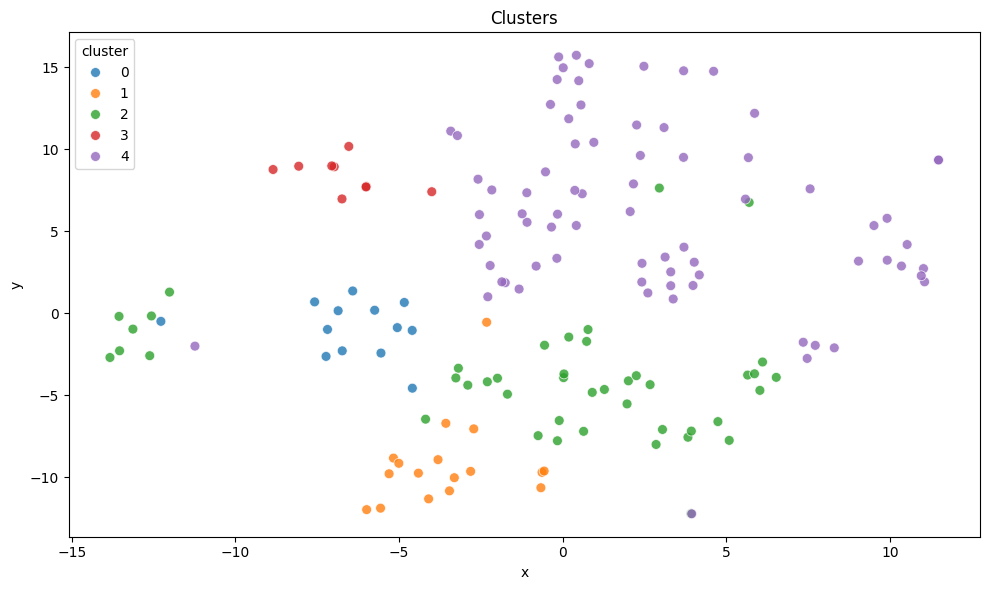

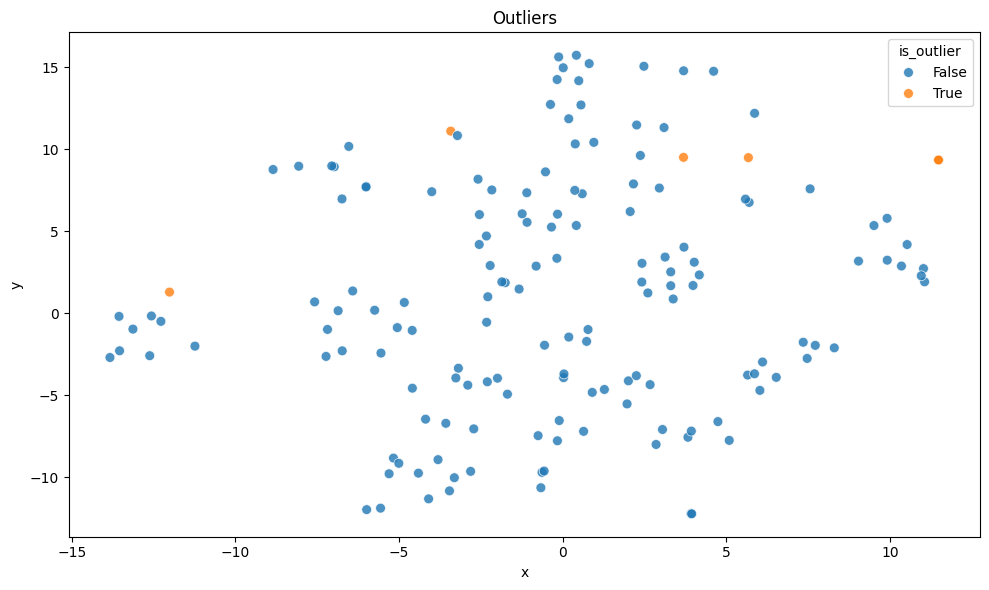

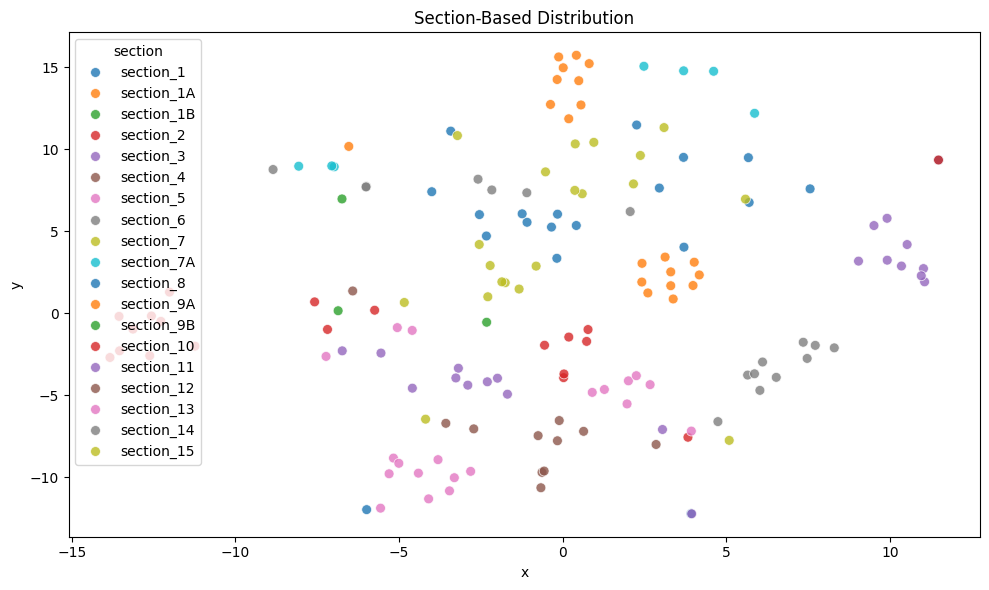

In [ ]:
'''
Step 10: Plotting - Scatter plot
Plot 1: Embeddings by assigned clusters
Plot 2: Embeddings by outlier flag
Plot 3: Embeddings by section number
'''
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scatter(df, color, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x="x", y="y", hue=color, palette="tab10", s=50, alpha=0.8)
    plt.title(title)
    plt.tight_layout()
    #Below code will save the plot into jpg into google drive. These plots are copied in /plots directory in github repo
    plt.savefig(title + '.jpg')
    plt.show()

plot_scatter(pandas_data, "cluster", "Clusters")
plot_scatter(pandas_data, "is_outlier", "Outliers")
plot_scatter(pandas_data, "section", "Section-Based Distribution")